Homework #2 2023

In [1]:
import numpy as np # arrays
import scipy.linalg as la
import matplotlib.pyplot as plt # plots 
import control as ct # control systems library
import cvxpy as cp
from collections import namedtuple
import time as tt

Utility functions

In [2]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a discrete-time system that models the behaviour 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, including a sampler and a ZOH converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    ZOH equivalent with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    y = np.zeros((controller.noutputs, 1))

    def updatefunction(t, x, u, params):  
        nonlocal step

        # Update the controller state only if it is time to sample
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0

        return x
           
    def outputfunction(t, x, u, params):
        nonlocal y
        
        # Compute controller action if it is time to sample
        if step == 0:
            y = controller._out(t, x, u)       
        return y

    # Return the controller system object
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [3]:
def quadratic_mpc_problem(p):
    """
    Generate a cvxpy problem for the quadratic MPC step
    p: Controller parameters
        A,B: Model
        N: Horizon length
        Q, R: State and input weights for stage cost
        Fx <= f: State constraints
        Eu <= e: Input constraints
        Xf: if == None, use the trivial zero terminal constraint
            if == 'lqr', compute an ellipsoidal terminal set
            and quadratic terminal cost based on lqr with weights Q, R
    Parameters:
    x0: initial state
    returns cvxpy problem object with x0 as parameter
    """
    
    # State and input dimension
    (nx, nu) = p.B.shape

    # Define initial state as parameter  
    x0 = cp.Parameter(nx, name='x0')

    # Define state and input variables
    x = cp.Variable((nx, p.N + 1), name='x') # From k=0 to k=N
    uc = cp.Variable((nu-1, p.N), name='uc')     # From k=0 to k=N-1
    ud = cp.Variable((1, p.N), name='ud', integer=True)
    u = cp.vstack([uc, ud])

    # Initialize cost and constraints
    cost = 0.0
    constraints = []
    
    # Generate cost and constraints
    for k in range(p.N):
        
        # Stage cost
        cost +=  cp.quad_form(x[:, k], p.Q)
        cost +=  cp.quad_form(u[:, k], p.R)

        # Dynamics constraint
        constraints += [x[:, k + 1] == p.A @ x[:, k] + p.B @ u[:, k]]

        # State constraints
        if p.F is not None:
            constraints += [p.F @ x[:, k] <= p.f.reshape(-1)]
            
        # Input constraints
        if p.E is not None:
            constraints += [p.E @ u[:, k] <= p.e.reshape(-1)]  
            constraints += [cp.norm(uc[:,k]) <= p.ub]
        
    # Terminal cost and constraint:
    # if unspecified, fall back to trivial terminal constraint
    if p.Xf == 'lqr': # Ellipsoidal/lqr set/cost
        cost += cp.quad_form(x[:, p.N], p.P)
        constraints += [cp.quad_form(x[:, p.N], p.Qt) <= 1]
    else:
        constraints += [x[:, p.N] == np.zeros_like(x0) ]
    


    # Initial state constraint
    constraints += [x[:, 0] == x0]

    # Generate cvx problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    # Return problem object
    return problem

In [4]:
def mpc_controller(parameters, T, **kwargs):
        """
        Create an I/O system implementing an MPC controller
        parameters: Controller parameters
            ref: Reference to be tracked
            A,B: Model
            N: Horizon length
            Q,R: Cost weights
        T: Sampling period
        """
        p = parameters
        typ = type
        nx, nu = p.B.shape
        no, _ = p.C.shape

        # Set up the cvxpy problem to be solved at each step
           
        # Generate cvxpy problem
        problem = quadratic_mpc_problem(p)
      
        # State x of the MPC controller is the current optimal sequence
        # while its input u is composed by current plant state
    
        # Controller state update function
        def _update(t, x, u, params={}):
            nonlocal nu, nx, p, problem
 
            # Retrieve current plant state (take out dummy input)
            x0 = u[-nx:]
            
            # Pass it to cvxpy
            problem.param_dict['x0'].value = x0
                
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve solution (optimal sequence) and return it
                res = np.vstack([problem.var_dict['uc'].value, problem.var_dict['ud'].value])
                return res.reshape(-1)

        # Controller output computation
        def _output(t, x, u, params={}):
            nonlocal nu, nx, p, problem
            
            # Retrieve current plant state (take out dummy input)
            x0 = u[-nx:]
            
            # Pass state (minus offset if tracking) to cvxpy
            problem.param_dict['x0'].value = x0
                
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve solution (optimal sequence)
                res = np.vstack([problem.var_dict['uc'].value, problem.var_dict['ud'].value])

                # Return first sample (plus offset if tracking)
                return res[:,0] 
               
        # Number of states of the controller    
        kwargs['states'] = nu * p.N
    
        return ct.NonlinearIOSystem(
            _update, _output, dt=T, **kwargs)

Main program

'Simulation time:'

20.8971164226532

'Energy: 2.028059477227969'

'Final state: '

array([-0.00800745,  0.00073295,  0.0043914 ,  0.00060205, -0.00120467,
        0.00965184])

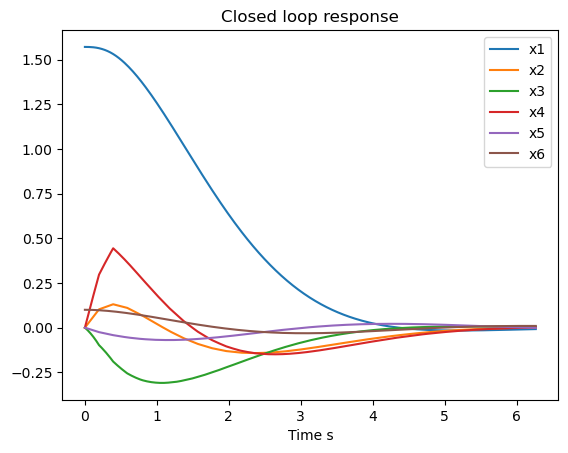

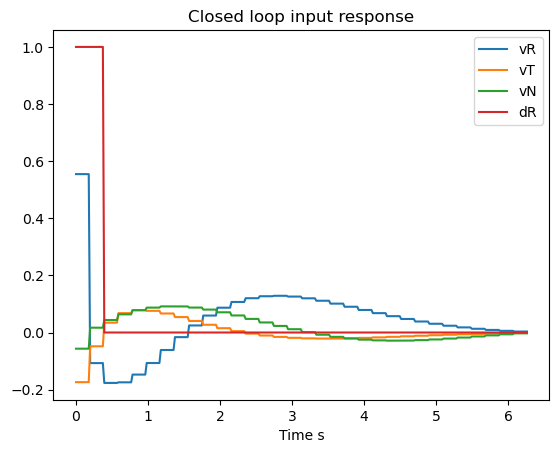

In [5]:
# Continuous-time plant model
A = np.array([ [0, 1, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, -1],
    [0, 0, 0, 0, 1, 0]])
B = np.array([[0, 0, 0, 0],
    [0, -3, 0, 0],
    [0, 2, 0, 0],
    [1, 0, 0, 1],
    [0, 0, 0.5, 0],
    [0, 0, 0, 0]])

C = np.eye(6)
D = np.zeros([6,4])

# B, D matrix without the discrete input
Br = B[:,:3]
Dr = np.zeros([6,3])

(no,nx) = C.shape
_, nu = B.shape

plant_continuous = ct.ss(A,B,C,D, 
                   inputs=['u[0]','u[1]','u[2]','u[3]'], states=['x[0]','x[1]','x[2]','x[3]','x[4]','x[5]'],
                   outputs=['x[0]','x[1]','x[2]','x[3]','x[4]','x[5]'])

# Controller sampling time
T = 2*np.pi/32

# This is the step to simulate the continuous time plant (and the closed loop)
simulation_dt = T/10

# Generate a discrete-time simulator of the plant with the simulation step
plant_simulator = ct.c2d(plant_continuous, simulation_dt, 'zoh')

# Generate discretized plant model for use with the controller
plant_discrete = ct.c2d(plant_continuous, T, 'zoh')

# Plant without the discrete input
plant_continuous_r = ct.ss(A,Br,C,Dr)
plant_discrete_r = ct.c2d(plant_continuous_r, T, 'zoh')

# MPC controller parameter structure field names
p = namedtuple('p', ['ref','A', 'B','C','N','Q','R','Rr','F','f','E','e','Xf','ub'])

p.A = plant_discrete.A
p.B = plant_discrete.B
p.C = plant_discrete.C

# Input constraints
p.E = np.array([[0, 0, 0, 1],
                [0, 0, 0 ,-1]])

# Norm bound on continuous input
p.ub = 1

p.e = np.array([[1],
                [1]])

# State constraints
p.F = np.array([[0, 0, 0, 1, 0, 0],
                [0, 0, 0, -1, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, -1, 0, 0, 0]])

p.f = np.array([[0.5],  
                [0.5],
                [0.5],
                [0.5]])


# Cost weights
p.Q = np.array([[0.5, 0, 0, 0, 0, 0],
                [0, 1.3, 0, 0, 0, 0],
                [0, 0, 1.5, 0, 0, 0],
                [0, 0, 0, 2, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1.7]])
p.Rr = 1.05*np.eye(3)
p.R = 1.05*la.block_diag(p.Rr, [0.2])


# Compute the nominal LQ controller, that uses only the continuous inputs
B1 = plant_discrete_r.B
K, p.P, _ = ct.dlqr(p.A, B1, p.Q, p.Rr)

# State constraints under the nominal controller
# We can avoid considering input constraints for terminal set because the first 3
# components are unconstrained in the problem!
Z = p.F
z = p.f
# Otherwise we can consider them but nothing changes
#K = np.vstack([K, np.zeros([1,nx])])
#Z = np.vstack((p.F,p.E @ K))
#z = np.vstack((p.f, p.e))

(nz, _) = Z.shape

# Compute the maximal sublevel set of the terminal cost x^T * P * x
# that lies within the constraints for the terminal controller
a = cp.Variable(nz)
gamma = cp.Variable(1)
epsi = np.finfo(float).eps

constraints = [gamma >= epsi]
for i in range(nz):
        constraints += [a[i] >= epsi]
        M2 = cp.bmat([[gamma*p.P, np.zeros([nx,1])],[np.zeros([1,nx]), [[-1]]]])
        M1 = cp.bmat([[np.zeros([nx,nx]), 0.5*Z[i,:].reshape(1,-1).T], [0.5*Z[i,:].reshape(1,-1), -z[i,:].reshape(1,-1)]])
        constraints += [-a[i]*M1 + M2 >> 0]

# This ensures that the terminal set stays inside the ellipsoidal input constraint
constraints += [-K.transpose() @ K / p.ub + gamma*p.P >> 0]  

problem = cp.Problem(cp.Minimize(gamma), constraints)
problem.solve(solver='MOSEK')
if problem.status != 'optimal':
        raise(ValueError("Infeasible problem in terminal set"))
else:
        # Terminal set x^T * Qt * x <= 1
        p.Qt = gamma.value * p.P




# Horizon length
p.N = 9

# Terminal set type
p.Xf = 'lqr'

# Define the MPC controller system object
controller = mpc_controller(p, T, 
                            inputs=['dummy','x[0]','x[1]','x[2]','x[3]','x[4]','x[5]'],
                            outputs=['u[0]','u[1]','u[2]','u[3]'])

# Create model of controller for simulation with the same integration time
# as the plant
controller_simulator = sampled_data_controller(controller, simulation_dt)

# Compute closed loop. The closed loop state has nu*p.N states (the controller states)
# plus nx states (the plant simulator states)
closedloop_simulator = ct.interconnect([controller_simulator, plant_simulator], 
                        inputs=['dummy'],
                        outputs=['x[0]','x[1]','x[2]','x[3]','x[4]','x[5]','u[0]','u[1]','u[2]','u[3]'],
                        states = nu*p.N + nx)

# Time vector for simulation
end_time = 2*np.pi
time = np.arange(0, end_time, simulation_dt)

# The controller state is the optimal input sequence: we initialize it to zero
initu = np.zeros(nu*p.N)

# Initial plant state
initx0 = np.array([np.pi/2,0,0,0,0,0.1])

# Closed loop initial state
initx = np.hstack((initu, initx0))

# Simulate
start_t = tt.time()
t, resp = ct.input_output_response(closedloop_simulator, time, 0, initx)
stop_t = tt.time()
display("Simulation time:", stop_t - start_t)

# Plot responses
y = resp[:no].T # extract output (first no components)
u = resp[-nu:].T # extract input (last nu components)

# Compute energy
nsteps, _ = u.shape
energy = 0
for tt in range(nsteps):
    energy += simulation_dt*(10*np.linalg.norm(u[tt,0:2])**2 + 2*u[tt,3]**2)

display(f"Energy: {energy}")
display("Final state: ", y[-1,:])

plt.plot(t, y, label=['x1','x2','x3','x4','x5','x6'])
#plt.plot(t, y3max*np.ones_like(t), 'g:', label='y3max')
#plt.plot(t, y3min*np.ones_like(t), 'g:', label='y3min')
#plt.plot(t, y1max*np.ones_like(t), 'b:', label='y1max')
plt.title("Closed loop response")
plt.xlabel("Time s")
plt.legend();
plt.figure()
plt.plot(t, u, label=['vR','vT','vN','dR'])
#plt.plot(t, umin*np.ones_like(t), 'k:', label='umin')
#plt.plot(t, umax*np.ones_like(t), 'k:', label='umax')
plt.xlabel("Time s")
plt.title("Closed loop input response")
plt.legend();